In [1]:
from keras.preprocessing.image import ImageDataGenerator 
def data_ready(): 
    images_dir = './images' 
    datagen = ImageDataGenerator(rotation_range=5, 
                                 shear_range=5, 
                                 validation_split=0.2, ) #20%를 검증모델로 사용. 
    train_generator = datagen.flow_from_directory(images_dir, target_size=(36,36), subset='training') 
    val_generator = datagen.flow_from_directory(images_dir, target_size=(36,36), subset='validation') 
    return train_generator, val_generator 

def load_image(img_path): 
    images_dir = img_path 
    datagen = ImageDataGenerator() 
    real_generator = datagen.flow_from_directory(images_dir, target_size=(36, 36)) 
    return real_generator

In [2]:
from keras import backend as K
from keras import layers as L
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [3]:
def Make_model(train,val):
    K.clear_session()

    model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
    reduce_lr = ReduceLROnPlateau(patience=8,verbose=1)
    early_stop = EarlyStopping(patience=20,verbose=2)

    entry = L.Input(shape=(36,36,3))
    x = L.SeparableConv2D(64,(3,3),activation='relu',padding ='same')(entry)
    x = L.BatchNormalization()(x)
    x = L.SeparableConv2D(64,(3,3),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Dropout(0.2)(x) 

    x = L.SeparableConv2D(128,(3,3),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.SeparableConv2D(128,(3,3),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Dropout(0.2)(x) 

    x = L.SeparableConv2D(256,(2,2),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.SeparableConv2D(256,(2,2),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.GlobalMaxPooling2D()(x)
    x = L.Dropout(0.2)(x)
    
    x = L.Dense(256)(x)
    x = L.LeakyReLU()(x)
    x = L.Dense(64, kernel_regularizer=l2(2e-4))(x)
    x = L.LeakyReLU()(x)
    x = L.Dense(26,activation='softmax')(x)

    model = Model(entry,x)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    history = model.fit(train,validation_data=val,epochs=100,
                        callbacks=[model_ckpt,reduce_lr,early_stop],
                        verbose=1)
    return history

In [4]:
def print_acc_loss(history):
    # 평가 결과 도식화
    import matplotlib.pyplot as plt
    fig, loss_ax = plt.subplots(figsize=(10, 5))
    acc_ax = loss_ax.twinx()
    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

In [5]:
def load_model():
    from keras.models import load_model
    model = load_model('BrailleNet.h5')
    return model

def acc_chk(model, val):
    acc = model.evaluate_generator(val)[1]
    print('model accuracy: {}'.format(round(acc,4)))

In [6]:
def alpha(num):

    if num == 26:
        return  ' '
    else:
        num_tr = num+97
        return chr(num_tr)

Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.
Epoch 1/100
39/39 [==============================] - 8s 216ms/step - loss: 3.9544 - accuracy: 0.0393 - val_loss: 3.2787 - val_accuracy: 0.0385
Epoch 2/100
39/39 [==============================] - 9s 227ms/step - loss: 3.2830 - accuracy: 0.0729 - val_loss: 3.2793 - val_accuracy: 0.0385
Epoch 3/100
39/39 [==============================] - 10s 244ms/step - loss: 3.1448 - accuracy: 0.1098 - val_loss: 3.2806 - val_accuracy: 0.0385
Epoch 4/100
39/39 [==============================] - 9s 230ms/step - loss: 2.9075 - accuracy: 0.1458 - val_loss: 3.2836 - val_accuracy: 0.0385
Epoch 5/100
39/39 [==============================] - 9s 232ms/step - loss: 2.5708 - accuracy: 0.2244 - val_loss: 3.2931 - val_accuracy: 0.0385
Epoch 6/100
39/39 [==============================] - 9s 236ms/step - loss: 2.2219 - accuracy: 0.3141 - val_loss: 3.3060 - val_accuracy: 0.0385
Epoch 7/100
39/39 [==============================] - 9s 

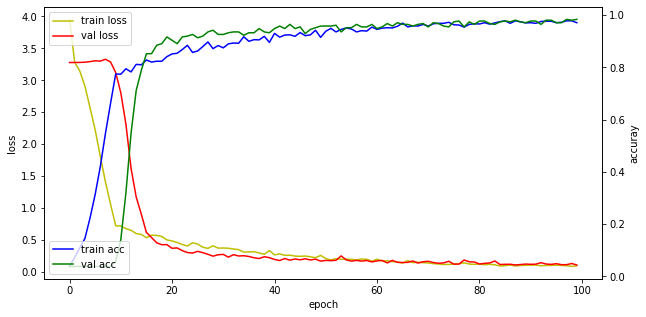

Instructions for updating:
Please use Model.evaluate, which supports generators.
model accuracy: 0.9776


In [7]:
train_generator, val_generator = data_ready()
hist = Make_model(train_generator,val_generator)
print_acc_loss(hist)
model = load_model()
acc = acc_chk(model,val_generator)

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
# real_generator = load_image('./test')
# result_list = model.predict_generator(real_generator)
# for result in result_list:
#     print(alpha(np.argmax(result)))

In [10]:
def predict_img(path):
    img_list = os.listdir(path)
    for img_file in img_list:
        if img_file.endswith('.jpg'):
            img = cv2.imread(os.path.join(path, img_file), cv2.IMREAD_COLOR)
            new_img = cv2.resize(img, dsize=(36, 36))
            new_img = new_img.reshape(1, 36, 36, 3)
            result = np.argmax(model.predict(new_img), axis=1)
            print(img_file,'->', alpha(result[0]))

In [11]:
predict_img('./test')

k1.JPG0whs.jpg -> k
m1.JPG0rot.jpg -> m
v1.JPG2rot.jpg -> v
d1.JPG0rot.jpg -> d
u1.JPG1rot.jpg -> u
r1.JPG1dim.jpg -> r
